<a href="https://colab.research.google.com/github/SlickMik/ensf692Project/blob/main/ENSF_692_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
%autosave 2

Autosaving every 2 seconds


# ESNF 692 Project
### Group # : 4
##### Authors : Danish Shahid () | Muhammad Ibrahim Khan ()
---

This notebook describes the correlation of asset classes - Oil, Gold, and S&P500 for a user selected time range

---

Importing Libraries

In [90]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib as mp
from matplotlib import pyplot as plt
import seaborn as sb

# Dataset Selection

Downloading Kaggle Datasets

In [33]:
# Download latest dataset versions
gold_dataset_path = kagglehub.dataset_download("faisaljanjua0555/daily-gold-price-historical-dataset")

oil_dataset_path = kagglehub.dataset_download("guillemservera/fuels-futures-data")

sp_dataset_path = kagglehub.dataset_download("youcanttouchthis/s-p-500-dataset")

# Dataset Creation

* Reading Dataset to Pandas<br/>
* Dropping unnecessary columns<br/>
* Setting index to Date<br/>
* Parsing Date

In [34]:
# read csv files into pandas
gold_dataset = pd.read_csv(gold_dataset_path + f'/gold.csv', index_col='Date', parse_dates=True)

oil_dataset = pd.read_csv(oil_dataset_path + f'/all_fuels_data.csv', index_col='date', parse_dates=True)

sp_dataset = pd.read_csv(sp_dataset_path + f'/spy.csv', index_col='Date', parse_dates=True)

Gold Dataset
* Dropping Columns
* Renaming Columns

Describing Gold Dataset

In [35]:
gold_dataset = gold_dataset.drop(columns='Currency').rename(columns = {c : f'Gold_{c}' for c in gold_dataset.columns})
gold_dataset.head(3)

,Gold_Open,Gold_High,Gold_Low,Gold_Close,Gold_Volume
Date,,,,,
2000-01-04,289.5,289.5,280.0,283.7,21621
2000-01-05,283.7,285.0,281.0,282.1,25448
2000-01-06,281.6,282.8,280.2,282.4,19055


Oil Dataset
* Dropping Columns
* Reorganizing Columns
* Renaming Columns
* Cleaning Columns

Describing Oil Dataset

In [36]:
oil_dataset = oil_dataset[oil_dataset['commodity'].str.lower().str.contains('crude')]
oil_dataset = oil_dataset.drop(columns=['ticker', 'commodity'])
oil_dataset.rename_axis(index={'date':'Date'}, inplace=True)
oil_dataset.columns = oil_dataset.columns.str.capitalize()

oil_dataset = (
    oil_dataset[['Open', 'High', 'Low', 'Close', 'Volume']]
    .rename(columns={c : f'Oil_{c.title()}' for c in oil_dataset.columns})
)
oil_dataset.head(3)

,Oil_Open,Oil_High,Oil_Low,Oil_Close,Oil_Volume
Date,,,,,
2000-08-23,31.950001,32.799999,31.950001,32.049999,79385
2000-08-24,31.900000,32.240002,31.400000,31.629999,72978
2000-08-25,31.700001,32.099998,31.320000,32.049999,44601


S&P 500 Dataset
* Dropping Columns
* Renaming Columns

Describing S&P 500 Dataset

In [37]:
sp_dataset = sp_dataset.drop(columns='Adj Close').rename(columns = {c : f'S&P500_{c}' for c in sp_dataset.columns})
sp_dataset.head(3)

,S&P500_Open,S&P500_High,S&P500_Low,S&P500_Close,S&P500_Volume
Date,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,201300


Join Datasets

In [38]:
assets_df = sp_dataset.join(gold_dataset, how='outer').join(oil_dataset, how='outer')
assets_df.head(3)

,S&P500_Open,S&P500_High,S&P500_Low,S&P500_Close,S&P500_Volume,Gold_Open,Gold_High,Gold_Low,Gold_Close,Gold_Volume,Oil_Open,Oil_High,Oil_Low,Oil_Close,Oil_Volume
Date,,,,,,,,,,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,1003200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,43.96875,44.25000,43.96875,44.25000,480500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-02,44.21875,44.37500,44.12500,44.34375,201300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Drop Unnecessary Price and Volume Columns

In [39]:
assets_df = assets_df.drop(columns=[x for x in assets_df.columns.unique() if 'Close' not in x], axis=1)

Drop Duplicated Columns If Any

In [40]:
if assets_df.columns.duplicated().any():
  assets_df = assets_df.T.drop_duplicates().T

Set Hierarchical Index on Rows

In [41]:
assets_df = assets_df.set_index(
    pd.MultiIndex.from_arrays(
        [assets_df.index.year,assets_df.index.month, assets_df.index.day], names=['Year', 'Month', 'Day']
        )
    )

Describing Joined Dataset after Hierarchical Indexing on Rows

In [42]:
assets_df.head(3)

S&P500_Close  Gold_Close  Oil_Close
Year Month Day                                     
1993 1     29       43.93750         NaN        NaN
     2     1        44.25000         NaN        NaN
           2        44.34375         NaN        NaN

---

# User Entry

In [43]:
print("Enter a start and end date between the range of 2000-08-01 & 2020-12-24 or enter 'n' to exit program")
min_date = pd.to_datetime('2000-08-01')
max_date = pd.to_datetime('2020-12-24')
status = True;

while status:
    try:
        start_date = pd.to_datetime(input('Enter the start date (e.g YYYY-MM-DD): '))
        end_date = pd.to_datetime(input('Enter the end date (e.g YYYY-MM-DD): '))
        rolling_period = int(input("Enter rolling period (e.g 20): "))
        if not (min_date <= start_date <= max_date):
            raise ValueError(f"Start date must be between {min_date.date()} and {max_date.date()}")
        if not (min_date <= end_date <= max_date):
            raise ValueError(f"End date must be between {min_date.date()} and {max_date.date()}")
        if start_date > end_date:
            raise ValueError("Start date must be before or equal to end date.")
        if rolling_period > 200:
            raise ValueError("Rolling period must be lower than 200")
        break
    except Exception as e:
        print(f"Invalid input: {e}")


Enter a start and end date between the range of 2000-08-01 & 2020-12-24 or enter 'n' to exit program
Enter the start date (e.g YYYY-MM-DD): 2000-08-01
Enter the end date (e.g YYYY-MM-DD): 2020-12-24
Enter rolling period (e.g 20): 20


Slicing Joined Asset Data Frame by Index

In [44]:
range_asset_df = assets_df.loc[(start_date.year, start_date.month, start_date.day):(end_date.year, end_date.month, end_date.day)]
range_asset_df.head(3)

S&P500_Close  Gold_Close  Oil_Close
Year Month Day                                     
2000 8     1       143.87500       283.2        NaN
           2       144.59375       282.8        NaN
           3       145.59375       279.5        NaN

---

# Analysis & Calculations

* Rolling Window SMA on price
* Rolling Window Correlation - pct change()
* Beta - returns - pct change()
* Seasonality heatmap - average returns
* Alpha? - returns

Rolling Window SMA Normalized Closing Price

In [45]:
sma_cols = {'S&P500_Close' : f'S&P500_Close_{rolling_period}-day_SMA',
            'Gold_Close' : f'Gold_Close_{rolling_period}-day_SMA',
            'Oil_Close' :  f'Oil_Close_{rolling_period}-day_SMA'}

In [46]:
range_asset_df[[*sma_cols.values()]] = (
    range_asset_df[[*sma_cols.keys()]].bfill().rolling(window=rolling_period).mean())

<ipython-input-46-61751402>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  range_asset_df[[*sma_cols.values()]] = (
<ipython-input-46-61751402>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  range_asset_df[[*sma_cols.values()]] = (
<ipython-input-46-61751402>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [80]:
sliced_df = range_asset_df[[*sma_cols.values()]]
#sma_df = (sliced_df - sliced_df.min()) / (sliced_df.max() - sliced_df.min())
sma_df = sliced_df/sliced_df.iloc[21]

Calculate Daily Price Change

In [48]:
perc_cols = {'S&P500_Close' : f'S&P500_Daily_%Return',
            'Gold_Close' : f'Gold_Daily_%Return',
            'Oil_Close' :  f'Oil_Daily_%Return'}

In [49]:
range_asset_df[[*perc_cols.values()]] = range_asset_df[[*perc_cols.keys()]].pct_change() * 100

<ipython-input-49-848564204>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  range_asset_df[[*perc_cols.values()]] = range_asset_df[[*perc_cols.keys()]].pct_change() * 100
<ipython-input-49-848564204>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  range_asset_df[[*perc_cols.values()]] = range_asset_df[[*perc_cols.keys()]].pct_change() * 100
<ipython-input-49-848564204>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Assets Closing Price Correlation

In [50]:
corr_cols = {'S&P500_Daily_%Return' : f'S&P500_Monthly_Corr',
            'Gold_Daily_%Return' : f'Gold_Monthly_Corr',
            'Oil_Daily_%Return' :  f'Oil_Monthly_Corr'}

In [51]:
corr_df = range_asset_df[[*corr_cols.values()]] = range_asset_df[[*corr_cols.keys()]].groupby(level=[0,1]).corr()

<ipython-input-51-1172548741>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df = range_asset_df[[*corr_cols.values()]] = range_asset_df[[*corr_cols.keys()]].groupby(level=[0,1]).corr()
<ipython-input-51-1172548741>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df = range_asset_df[[*corr_cols.values()]] = range_asset_df[[*corr_cols.keys()]].groupby(level=[0,1]).corr()
<ipython-input-51-1172548741>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [52]:
test = corr_df.unstack().loc[:, [('S&P500_Daily_%Return', 'Gold_Daily_%Return'), ('S&P500_Daily_%Return','Oil_Daily_%Return'),
                          ('Gold_Daily_%Return', 'Oil_Daily_%Return')]]

In [53]:
test.columns = ["_".join(a) for a in test.columns.to_flat_index()]

In [54]:
test

S&P500_Daily_%Return_Gold_Daily_%Return  \
Year Month                                            
2000 8                                     0.092598   
     9                                     0.184241   
     10                                   -0.250742   
     11                                    0.061819   
     12                                   -0.358140   
...                                             ...   
2020 8                                     0.501537   
     9                                     0.224276   
     10                                    0.314862   
     11                                   -0.094728   
     12                                    0.704323   

            S&P500_Daily_%Return_Oil_Daily_%Return  \
Year Month                                           
2000 8                                   -0.548231   
     9                                   -0.221359   
     10                                  -0.462368   
     11                                   0.292880   
     12                                   0.208115   
...                                            ...   
2020 8                                   -0.335059   
     9                                    0.266693   
     10                                   0.142624   
     11                                  -0.179022   
     12                                  -0.095760   

            Gold_Daily_%Return_Oil_Daily_%Return  
Year Month                                        
2000 8                                 -0.451255  
     9                                 -0.308667  
     10                                 0.671629  
     11                                -0.339662  
     12                                -0.027945  
...                                          ...  
2020 8                                  0.077359  
     9                                  0.146618  
     10                                 0.070128  
     11                                -0.061935  
     12                                -0.208294  

[245 rows x 3 columns]

In [55]:
# plotting correlation

Asset SMA Closing Price Correlation

In [56]:
# calculating correlation

In [57]:
# plotting correlation

In [77]:
monthlyReturns = range_asset_df[[*perc_cols.values()]].groupby(['Year', 'Month']).sum().groupby('Month').mean()

In [78]:
monthlyReturns

,S&P500_Daily_%Return,Gold_Daily_%Return,Oil_Daily_%Return
Month,,,
1,0.168940,3.126353,13.752944
2,-0.297540,1.142195,21.151726
3,0.326490,-0.174139,14.560111
4,2.699691,0.869730,7.068106
5,0.621990,0.502201,15.338743
6,-0.905087,-0.268175,14.066407
7,1.353209,1.433731,10.733662
8,0.414121,1.994213,16.097832
9,-1.290325,0.572977,12.369351


---

# Export & Matplotlib

SMA Plot

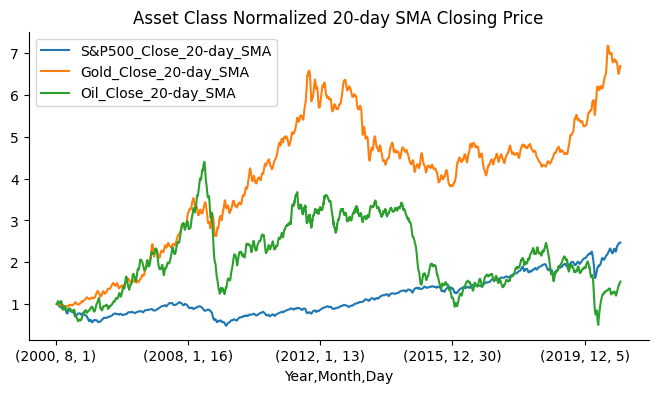

In [81]:
sma_df.plot(kind='line', figsize=(8, 4), title=f'Asset Class Normalized {rolling_period}-day SMA Closing Price')
plt.gca().spines[['top', 'right']].set_visible(False)

Corr_Plot - bar char level from 0

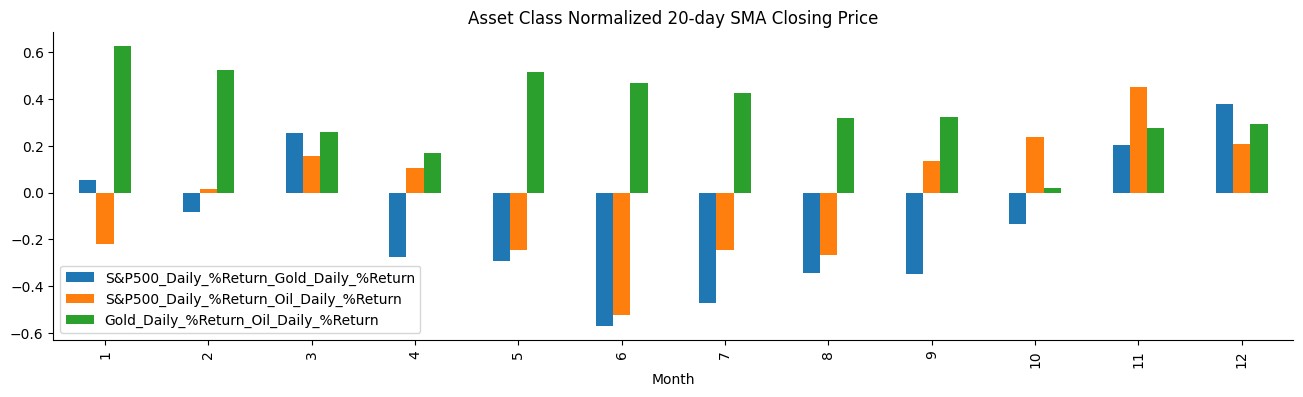

In [82]:
test.loc[2008].plot(kind='bar', figsize=(16, 4), title=f'Asset Class Normalized {rolling_period}-day SMA Closing Price')
plt.gca().spines[['top', 'right']].set_visible(False)

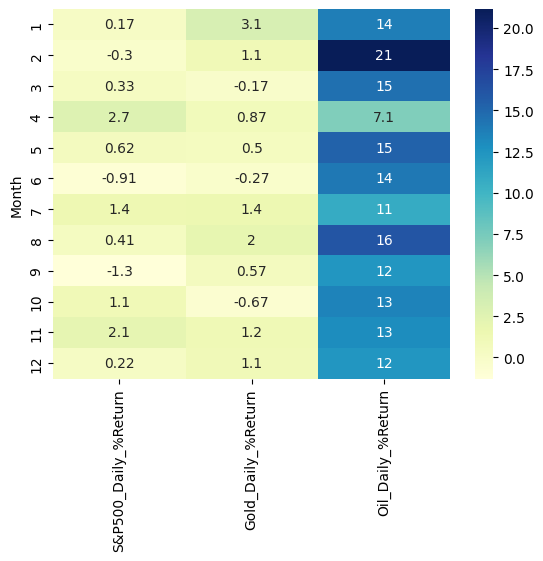

In [91]:
sb.heatmap(monthlyReturns, annot=True, cmap="YlGnBu")
plt.show()